<a href="https://colab.research.google.com/github/sandipanpaul21/NLP-using-Python/blob/master/10_SMS_Spam_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries 

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Importing file from Google Drive
# Raw File -  Please find the attachment in same Repository

from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
file_url = '/content/drive/My Drive/Colab Notebooks/spam.csv'
data = pd.read_csv(file_url,encoding='latin-1')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# select first two columns
data_v2 = data[data.columns[0:2]]
messages = data_v2.rename(columns={'v1': 'label','v2': 'message'})
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Exploratory Data Analysis

# Let's check out some of the stats with some plots and the built-in methods in pandas!
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [6]:
# Let's make a new column to detect how long the text messages are.

# This will be a new feature that will help us to determine if the message is spam or ham.
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Message Length Visualization
count    5572.000
mean       80.119
std        59.691
min         2.000
25%        36.000
50%        61.000
75%       121.000
max       910.000
Name: length, dtype: float64


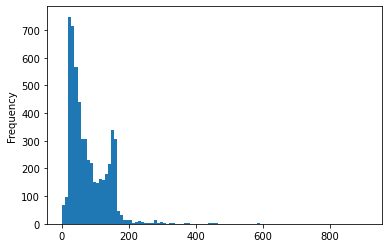

In [7]:
# Data Visualization

print("Message Length Visualization")
print(messages.length.describe().round(3))
messages['length'].plot(bins=100, kind='hist') 

# Inference :
# Woah! 910 characters

In [8]:
# 910 characters, let's use masking to find this message:

messages[messages['length'] == 910]['message'].iloc[0]

# Inference :
# Looks like we have some sort of Romeo sending texts!

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f06c5a64f60>,
      dtype=object)

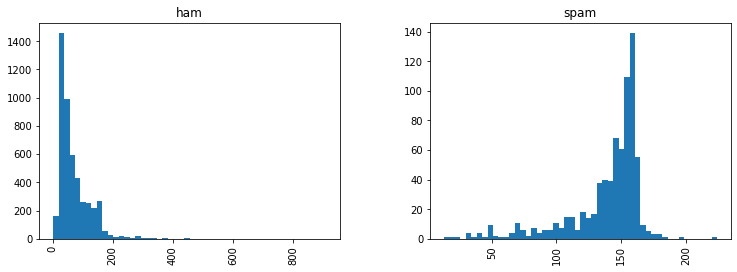

In [9]:
# If message length is a distinguishing feature between ham and spam

messages.hist(column='length', by='label', bins=50,figsize=(12,4))

# Inference : 
# Very interesting! Through just basic EDA we've been able to discover a trend 
# that spam messages tend to have more characters. (Sorry Romeo!)

In [10]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [11]:
# Each vector will have as many dimensions as there are unique words in the SMS corpus.
# We will first use SciKit Learn's CountVectorizer.
# This model will convert a collection of text documents to a matrix of token counts.
# We can imagine this as a 2-Dimensional matrix.
# Where the 1-dimension is the entire vocabulary (1 row per word) and 
# the other dimension are the actual documents, in this case a column per text message.

bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11304


In [12]:
# Now we can use .transform on our Bag-of-Words (bow) transformed object 
# and transform the entire DataFrame of messages. 
# bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

messages_bow = bow_transformer.transform(messages['message'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11304)
Amount of Non-Zero occurences:  50193


In [13]:
# Sparsity in the Dataset

sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [14]:
# To transform the entire bag-of-words corpus into TF-IDF corpus at once:

tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

# There are many ways the data can be preprocessed and vectorized.
# This is just one way of doing the same.

(5572, 11304)


In [15]:
# Training a model

# With messages represented as vectors,
# we can finally train our spam/ham classifier.
# Now we can actually use almost any sort of classification algorithms.
# For a variety of reasons, the Naive Bayes classifier algorithm is a good choice.

spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])
spam_detect_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [16]:
# Model Evaluation

# Now we want to determine how well our model will do overall on the entire dataset.
# Let's begin by getting all the predictions:

all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [17]:
# Model Result
print (classification_report(messages['label'], all_predictions))

# In the above "evaluation",we evaluated accuracy on the same data we used for training. 
# You should never actually evaluate on the same dataset you train on!
# Such evaluation tells us nothing about the true predictive power of our model.
# If we simply remembered each example during training, 
# the accuracy on training data would trivially be 100%,
# even though we wouldn't be able to classify any new messages.

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In [18]:
# Train Test Split

# A proper way is to split the data into a training/test set,
# where the model only ever sees the training data during its model fitting and parameter tuning.
# The test data is never used in any way.
# This is then our final evaluation on test data is representative of true predictive performance.

msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

# Inference : 
# The test size is 20% of the entire dataset (1112 messages out of total 5559),
# and the training is the rest (4447 out of 5559).
# Note the default split would have been 30/70.

4457 1115 5572


In [19]:
# Creating a Data Pipeline

# Let's run our model again and then predict off the test set.
# We will use SciKit Learn's pipeline capabilities to store a pipeline of workflow.
# This will allow us to set up all the transformations that we will do to the data for future use.

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [20]:
# Now we can directly pass message text data and the pipeline will do our pre-processing for us
# We can treat it as a model/estimator API:

pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f06c53ef598>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [21]:
# Prediction Result

predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98       999
        spam       0.74      1.00      0.85       116

    accuracy                           0.96      1115
   macro avg       0.87      0.98      0.91      1115
weighted avg       0.97      0.96      0.97      1115

